<a href="https://colab.research.google.com/github/edgarMuno/TFM/blob/main/CNNTFM_implement_FIle_npz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/MyDrive/TFM/Abuse/Train_process-20250312T191959Z-001.zip" -d "/content/drive/MyDrive/TFM/Train/"

Archive:  /content/drive/MyDrive/TFM/Abuse/Train_process-20250312T191959Z-001.zip
  inflating: /content/drive/MyDrive/TFM/Train/Train_process/Shooting.npz  
  inflating: /content/drive/MyDrive/TFM/Train/Train_process/Normal_Video_36.npz  
  inflating: /content/drive/MyDrive/TFM/Train/Train_process/Vandalism.npz  
  inflating: /content/drive/MyDrive/TFM/Train/Train_process/Normal_Video_37.npz  
  inflating: /content/drive/MyDrive/TFM/Train/Train_process/Normal_Video_38.npz  
  inflating: /content/drive/MyDrive/TFM/Train/Train_process/Normal_Video_41.npz  
  inflating: /content/drive/MyDrive/TFM/Train/Train_process/Normal_Video_35.npz  
  inflating: /content/drive/MyDrive/TFM/Train/Train_process/Normal_Video_45.npz  
  inflating: /content/drive/MyDrive/TFM/Train/Train_process/Normal_Video_27.npz  
  inflating: /content/drive/MyDrive/TFM/Train/Train_process/Normal_Video_23.npz  
  inflating: /content/drive/MyDrive/TFM/Train/Train_process/Normal_Video_25.npz  
  inflating: /content/drive/M

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
processed_path = "/content/drive/MyDrive/TFM/Train/Train_process/"
processed_path_test = "/content/drive/MyDrive/TFM/Test/Test_process/"

In [3]:
import os
import numpy as np
import tensorflow as tf


class_files = sorted(os.listdir(processed_path))

# 🔹 Configuración del dataset
BATCH_SIZE = 64
IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_CLASSES = 14
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",
                'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

def npz_generator():
    """Generador que carga los datos desde los archivos .npz en lotes"""
    for file in class_files:
        file_path = os.path.join(processed_path, file)
        data = np.load(file_path, allow_pickle=True)
        X, y = data["X"], data["y"]

        # 🔹 Convertir imágenes de 1 canal a 3 canales (RGB para DenseNet121)
        X = np.repeat(X, 3, axis=-1)  # (64, 64, 1) → (64, 64, 3)

        # 🔹 Convertir etiquetas a números
        class_to_index = {class_name: idx for idx, class_name in enumerate(CLASS_LABELS)}
        y = np.array([class_to_index[label] for label in y])  # Convertir etiquetas

        # 🔹 One-hot encoding
        y = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

        for i in range(0, len(X), BATCH_SIZE):
            yield X[i:i+BATCH_SIZE], y[i:i+BATCH_SIZE]

# 🔹 Crear el dataset de TensorFlow SIN `batch(BATCH_SIZE)`
train_dataset = tf.data.Dataset.from_generator(
    npz_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32)
    )
).prefetch(tf.data.experimental.AUTOTUNE)

print("✅ Dataset en streaming corregido y cargado correctamente.")


✅ Dataset en streaming corregido y cargado correctamente.


In [ ]:
# 🔹 Generador para cargar datos de validación desde los `.npz`
def npz_test_generator():
    """Generador que carga los datos de validación desde los archivos .npz en lotes"""
    for file in class_files:
        file_path = os.path.join(processed_path_test, file)
        data = np.load(file_path, allow_pickle=True)
        X, y = data["X"], data["y"]

        # 🔹 Convertir imágenes de 1 canal a 3 canales (RGB para DenseNet121)
        X = np.repeat(X, 3, axis=-1)  # (64, 64, 1) → (64, 64, 3)

        # 🔹 Convertir etiquetas a números
        class_to_index = {class_name: idx for idx, class_name in enumerate(CLASS_LABELS)}
        y = np.array([class_to_index[label] for label in y])  # Convertir etiquetas

        # 🔹 One-hot encoding
        y = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

        for i in range(0, len(X), BATCH_SIZE):
            yield X[i:i+BATCH_SIZE], y[i:i+BATCH_SIZE]

# 🔹 Crear el dataset de validación
test_dataset = tf.data.Dataset.from_generator(
    npz_test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32)
    )
).prefetch(tf.data.experimental.AUTOTUNE)

print("✅ Dataset de validación cargado correctamente.")


✅ Dataset de validación cargado correctamente.


In [ ]:
def feature_extractor(inputs):
    base_model = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                                   include_top=False,
                                                   weights="imagenet")(inputs)
    return base_model

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.00003),
                loss='categorical_crossentropy',
                metrics=[tf.keras.metrics.AUC()])

    return model

# 🔹 Crear el modelo
model = define_compile_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 2, 2, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 14)                  │           7,182 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,095,054 (30.88 MB)

 Trainable params: 8,011,406 (30.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
# 📂 Contar el total de imágenes en entrenamiento y validación
total_train_images = sum([np.load(os.path.join(processed_path, file))["X"].shape[0] for file in class_files])
total_test_images = total_train_images * 0.2  # 20% de los datos como validación

# 🔹 Calcular los steps por epoch
steps_per_epoch = total_train_images // BATCH_SIZE
validation_steps = int(total_test_images) // BATCH_SIZE

print(f"✅ Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")


✅ Steps per epoch: 6423, Validation steps: 1284


In [ ]:
# 📂 Contar el total de imágenes en el dataset procesado
total_images = sum([np.load(os.path.join(processed_path, file))["X"].shape[0] for file in class_files])

# 🔹 Calcular el número de pasos por epoch
steps_per_epoch = total_images // BATCH_SIZE
print(f"✅ Total de imágenes: {total_images}, Steps per epoch: {steps_per_epoch}")


✅ Total de imágenes: 411126, Steps per epoch: 6423


In [ ]:
# 🔹 Entrenar el modelo con validación en cada epoch
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=1,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


6423/6423 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc_1: 0.9698 - loss: 0.5885

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/TFM/Test/Test_process/Normal_Video_22.npz'
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-12-4a4a7d46d344>", line 6, in npz_test_generator
    data = np.load(file_path, allow_pickle=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/numpy/lib/npyio.py", line 427, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/TFM/Test/Test_process/Normal_Video_22.npz'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/TFM/Test/Test_process/Normal_Video_22.npz'
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-12-4a4a7d46d344>", line 6, in npz_test_generator
    data = np.load(file_path, allow_pickle=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/numpy/lib/npyio.py", line 427, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/TFM/Test/Test_process/Normal_Video_22.npz'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_187031]

In [ ]:
# 🔹 Entrenar el modelo con los `.npz` en streaming
history = model.fit(train_dataset, epochs=4)


Epoch 1/4
   3190/Unknown 489s 128ms/step - auc_1: 0.8969 - loss: 1.3085

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


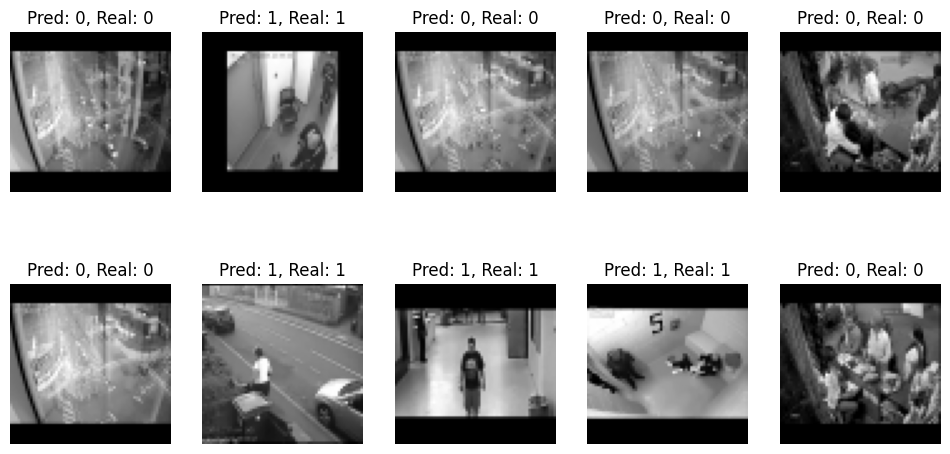

In [ ]:
import matplotlib.pyplot as plt

# Obtener predicciones
y_pred = model.predict(X_test[:10])
y_pred_binario = (y_pred > 0.5).astype(int)

# Mostrar imágenes con predicción
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(X_test[i].reshape(64, 64), cmap='gray')
    axes[i].set_title(f"Pred: {y_pred_binario[i][0]}, Real: {y_test[i]}")
    axes[i].axis('off')

plt.show()


Nueva ejecucicon

In [3]:
train_path = "/content/drive/MyDrive/TFM/Train/Train_process/"
test_path = "/content/drive/MyDrive/TFM/Test/Test_process/"

In [11]:
import os
import numpy as np
import tensorflow as tf

# 📂 Rutas de los archivos preprocesados


# 🔹 Configuración
BATCH_SIZE = 64
IMG_HEIGHT = 64
IMG_WIDTH = 64
EPOCHS = 4
LR =  0.00003
NUM_CLASSES = 14
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"NormalVideos",
                'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

def npz_generator(folder_path):
    """Generador que carga los datos desde los archivos .npz en lotes pequeños, fusionando Normal*.npz"""
    class_files = sorted(os.listdir(folder_path))

    # Fusionar archivos de "Normal" (Normal1.npz, Normal2.npz, ...)
    normal_files = [f for f in class_files if "Normal" in f]
    other_files = [f for f in class_files if "Normal" not in f]

    all_files = normal_files + other_files  # Asegurar que los de Normal estén juntos

    for file in all_files:
        file_path = os.path.join(folder_path, file)
        data = np.load(file_path, allow_pickle=True)
        X, y = data["X"], data["y"]

        # 🔹 Convertir imágenes de 1 canal a 3 canales (RGB para DenseNet121)
        X = np.repeat(X, 3, axis=-1)  # (64, 64, 1) → (64, 64, 3)
        y = np.where(y == "NormalVideos", "Normal", y)  # Reemplazar "NormalVideos" por "Normal"

        # 🔹 Convertir etiquetas a números
        class_to_index = {class_name: idx for idx, class_name in enumerate(CLASS_LABELS)}
        y = np.array([class_to_index[label] for label in y])  # Convertir etiquetas

        # 🔹 One-hot encoding
        y = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

        for i in range(0, len(X), BATCH_SIZE):
            yield X[i:i+BATCH_SIZE], y[i:i+BATCH_SIZE]


In [6]:
# 🔹 Crear datasets en streaming
train_dataset = tf.data.Dataset.from_generator(
    lambda: npz_generator(train_path),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32)
    )
).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: npz_generator(test_path),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32)
    )
).prefetch(tf.data.experimental.AUTOTUNE)

print("✅ Datasets en streaming cargados correctamente.")


✅ Datasets en streaming cargados correctamente.


In [7]:
# 📂 Contar el total de imágenes en entrenamiento y validación
total_train_images = sum([np.load(os.path.join(train_path, file))["X"].shape[0] for file in sorted(os.listdir(train_path))])
total_test_images = sum([np.load(os.path.join(test_path, file))["X"].shape[0] for file in sorted(os.listdir(test_path))])

# 🔹 Calcular los steps por epoch
steps_per_epoch = total_train_images // BATCH_SIZE
validation_steps = total_test_images // BATCH_SIZE
print(total_train_images)
print(total_test_images)
print(total_train_images+total_train_images)
print(f"✅ Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")


831126
111308
1662252
✅ Steps per epoch: 12986, Validation steps: 1739


In [ ]:
import os
import numpy as np



# 🔹 Obtener solo los archivos que contienen "Normal"
normal_files = sorted([f for f in os.listdir(train_path) if "Normal" in f])

print("📂 Archivos de Normal detectados:", normal_files)

# 🔹 Revisar las etiquetas de cada archivo
for file in normal_files:
    file_path = os.path.join(train_path, file)
    data = np.load(file_path, allow_pickle=True)

    unique_labels = np.unique(data["y"])  # Obtener todas las etiquetas únicas en este archivo
    print(f"✅ Archivo: {file} | Etiquetas únicas: {unique_labels}")

    if len(unique_labels) > 1 or unique_labels[0] != "Normal":
        print("❌ ERROR: Se detectaron etiquetas incorrectas en", file)


📂 Archivos de Normal detectados: ['Normal_Video_1.npz', 'Normal_Video_10.npz', 'Normal_Video_11.npz', 'Normal_Video_12.npz', 'Normal_Video_13.npz', 'Normal_Video_2.npz', 'Normal_Video_20.npz', 'Normal_Video_21.npz', 'Normal_Video_22.npz', 'Normal_Video_23.npz', 'Normal_Video_24.npz', 'Normal_Video_25.npz', 'Normal_Video_26.npz', 'Normal_Video_27.npz', 'Normal_Video_28.npz', 'Normal_Video_3.npz', 'Normal_Video_30.npz', 'Normal_Video_31.npz', 'Normal_Video_35.npz', 'Normal_Video_36.npz', 'Normal_Video_37.npz', 'Normal_Video_38.npz', 'Normal_Video_39.npz', 'Normal_Video_4.npz', 'Normal_Video_40.npz', 'Normal_Video_41.npz', 'Normal_Video_42.npz', 'Normal_Video_44.npz', 'Normal_Video_45.npz', 'Normal_Video_5.npz', 'Normal_Video_6.npz', 'Normal_Video_7.npz', 'Normal_Video_8.npz', 'Normal_Video_9.npz']
✅ Archivo: Normal_Video_1.npz | Etiquetas únicas: ['Normal']
✅ Archivo: Normal_Video_10.npz | Etiquetas únicas: ['Normal']
✅ Archivo: Normal_Video_11.npz | Etiquetas únicas: ['Normal']
✅ Archiv

KeyboardInterrupt: 

In [8]:
def feature_extractor(inputs):
    base_model = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                                   include_top=False,
                                                   weights="imagenet")(inputs)
    return base_model

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LR),
                loss='categorical_crossentropy',
                metrics=[tf.keras.metrics.AUC()])

    return model

# 🔹 Crear el modelo
model = define_compile_model()
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 2, 2, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 14)                  │           7,182 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,095,054 (30.88 MB)

 Trainable params: 8,011,406 (30.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [9]:
# 🔹 Entrenar el modelo con validación en cada epoch
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Epoch 1/4
12986/12986 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - auc: 0.9580 - loss: 0.6403

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  KeyError: 'NormalVideos'
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-5-e935e5cd093e>", line 38, in npz_generator
    y = np.array([class_to_index[label] for label in y])  # Convertir etiquetas
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-5-e935e5cd093e>", line 38, in <listcomp>
    y = np.array([class_to_index[label] for label in y])  # Convertir etiquetas
                  ~~~~~~~~~~~~~~^^^^^^^

KeyError: 'NormalVideos'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) UNKNOWN:  KeyError: 'NormalVideos'
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-5-e935e5cd093e>", line 38, in npz_generator
    y = np.array([class_to_index[label] for label in y])  # Convertir etiquetas
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-5-e935e5cd093e>", line 38, in <listcomp>
    y = np.array([class_to_index[label] for label in y])  # Convertir etiquetas
                  ~~~~~~~~~~~~~~^^^^^^^

KeyError: 'NormalVideos'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_235569]

In [3]:
import os
import numpy as np

# 📂 Ruta del archivo de Test a corregir
file_name = "Normal.npz"  # Nombre del archivo a corregir
file_path = os.path.join(test_path, file_name)

# 🔹 Cargar el archivo
data = np.load(file_path, allow_pickle=True)
X, y = data["X"], data["y"]

# 🔹 Corregir etiquetas incorrectas
y_fixed = np.where(y == "NormalVideos", "Normal", y)  # Reemplazar "NormalVideos" → "Normal"

# 🔹 Guardar el archivo corregido
save_path = os.path.join(test_path, "Normal_1.npz")  # Nuevo nombre para evitar sobrescribir
np.savez_compressed(save_path, X=X, y=y_fixed)

print(f"✅ Etiquetas corregidas y guardadas en: {save_path}")

# 🔹 Verificar que el cambio fue exitoso
data_fixed = np.load(save_path, allow_pickle=True)
print("✅ Etiquetas únicas después de la corrección:", np.unique(data_fixed["y"]))


✅ Etiquetas corregidas y guardadas en: /content/drive/MyDrive/TFM/Test/Test_process/Normal_1.npz
✅ Etiquetas únicas después de la corrección: ['Normal']


In [18]:
import os
import numpy as np
train_path='/content/drive/MyDrive/TFM/Train/Train_process/Normal'
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",
                'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']
# 📂 Ruta de los archivos preprocesados en Test
# 🔹 Revisar las etiquetas en cada archivo .npz
for file in sorted(os.listdir(train_path)):
    file_path = os.path.join(train_path, file)
    data = np.load(file_path, allow_pickle=True)

    unique_labels = np.unique(data["y"])  # Obtener todas las etiquetas únicas en este archivo
   # print(unique_labels)
    print(f"📂 Archivo: {file} | Etiquetas únicas: {unique_labels}")

    # 🔹 Validar que las etiquetas están dentro de CLASS_LABELS

    incorrect_labels = [label for label in unique_labels if label not in CLASS_LABELS]
    if incorrect_labels:
        print(f"❌ ERROR: Se detectaron etiquetas incorrectas en {file} → {incorrect_labels}")

📂 Archivo: Normal_Video_1.npz | Etiquetas únicas: ['Normal']
📂 Archivo: Normal_Video_10.npz | Etiquetas únicas: ['Normal']
📂 Archivo: Normal_Video_11.npz | Etiquetas únicas: ['Normal']


KeyError: 'y is not a file in the archive'

In [7]:
import os
import numpy as np

# 📂 Ruta de los archivos preprocesados en Train

train_path='/content/drive/MyDrive/TFM/Train/Train_process/Normal'
# 🔹 Obtener todos los archivos .npz en Train/
train_files = sorted(os.listdir(train_path))

for file in train_files:
    file_path = os.path.join(train_path, file)
    data = np.load(file_path, allow_pickle=True)

    X, y = data["X"], data["y"]

    # 🔹 Corregir etiquetas incorrectas
    y_fixed = np.array(["Normal" if "Normal_Video" in label else label for label in y])

    # 🔹 Guardar el archivo corregido
    save_path = os.path.join(train_path, f"{file}")  # No sobrescribe el original
    np.savez_compressed(save_path, X=X, y=y_fixed)

    print(f"✅ Archivo corregido: {file} → {save_path}")




✅ Archivo corregido: Normal_Video_1.npz → /content/drive/MyDrive/TFM/Train/Train_process/Normal/Normal_Video_1.npz
✅ Archivo corregido: Normal_Video_10.npz → /content/drive/MyDrive/TFM/Train/Train_process/Normal/Normal_Video_10.npz
✅ Archivo corregido: Normal_Video_11.npz → /content/drive/MyDrive/TFM/Train/Train_process/Normal/Normal_Video_11.npz
✅ Archivo corregido: Normal_Video_12.npz → /content/drive/MyDrive/TFM/Train/Train_process/Normal/Normal_Video_12.npz
✅ Archivo corregido: Normal_Video_13.npz → /content/drive/MyDrive/TFM/Train/Train_process/Normal/Normal_Video_13.npz
✅ Archivo corregido: Normal_Video_14.npz → /content/drive/MyDrive/TFM/Train/Train_process/Normal/Normal_Video_14.npz
✅ Archivo corregido: Normal_Video_15.npz → /content/drive/MyDrive/TFM/Train/Train_process/Normal/Normal_Video_15.npz
✅ Archivo corregido: Normal_Video_16.npz → /content/drive/MyDrive/TFM/Train/Train_process/Normal/Normal_Video_16.npz
✅ Archivo corregido: Normal_Video_17.npz → /content/drive/MyDrive/

In [19]:
import os
import numpy as np

# 📂 Ruta de los archivos preprocesados en Train
train_path = "/content/drive/MyDrive/TFM/Train/Train_process/Normal"

# 🔹 Definir las clases correctas
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",
                'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

# 🔹 Revisar y corregir etiquetas en cada archivo .npz
for file in sorted(os.listdir(train_path)):
    file_path = os.path.join(train_path, file)
    data = np.load(file_path, allow_pickle=True)

    X, y = data["X"], data["y"]

    # 🔹 Detectar etiquetas incorrectas
    incorrect_labels = [label for label in np.unique(y) if label not in CLASS_LABELS]

    if incorrect_labels:
        print(f"❌ ERROR en {file}: {incorrect_labels} → Corrigiendo...")

        # 🔹 Corregir etiquetas incorrectas reemplazándolas por "Normal"
        y_fixed = np.array(["Normal" if label not in CLASS_LABELS else label for label in y])

        # 🔹 Guardar el archivo corregido
        save_path = os.path.join(train_path, f"{file}_fixed.npz")  # No sobrescribe el original
        np.savez_compressed(save_path, X=X, y=y_fixed)

        print(f"✅ Archivo corregido: {file} → {save_path}")

# 🔹 Verificar etiquetas después de la corrección
for file in sorted(os.listdir(train_path)):
    if "_fixed.npz" in file:  # Cargar solo los archivos corregidos
        file_path = os.path.join(train_path, file)
        data_fixed = np.load(file_path, allow_pickle=True)
        unique_labels = np.unique(data_fixed["y"])
        print(f"📂 Archivo corregido: {file} | Etiquetas únicas: {unique_labels}")


error: Error -3 while decompressing data: invalid block type

In [17]:
# 🔹 Verificar etiquetas después de la corrección
for file in train_files:
    file_path = os.path.join(train_path, f"{file}")  # Cargar los archivos corregidos
    data_fixed = np.loa(file_path, allow_pickle=True)
    unique_labels = np.unique(data_fixed["y"])
    print(f"📂 Archivo corregido: {file}_fixed.npz | Etiquetas únicas: {unique_labels}")

📂 Archivo corregido: Normal_Video_1.npz_fixed.npz | Etiquetas únicas: ['Normal']
📂 Archivo corregido: Normal_Video_10.npz_fixed.npz | Etiquetas únicas: ['Normal']
📂 Archivo corregido: Normal_Video_11.npz_fixed.npz | Etiquetas únicas: ['Normal']
📂 Archivo corregido: Normal_Video_12.npz_fixed.npz | Etiquetas únicas: ['Normal']
📂 Archivo corregido: Normal_Video_13.npz_fixed.npz | Etiquetas únicas: ['Normal']
📂 Archivo corregido: Normal_Video_14.npz_fixed.npz | Etiquetas únicas: ['Normal']
📂 Archivo corregido: Normal_Video_15.npz_fixed.npz | Etiquetas únicas: ['Normal']
📂 Archivo corregido: Normal_Video_16.npz_fixed.npz | Etiquetas únicas: ['Normal']
📂 Archivo corregido: Normal_Video_17.npz_fixed.npz | Etiquetas únicas: ['Normal']
📂 Archivo corregido: Normal_Video_18.npz_fixed.npz | Etiquetas únicas: ['Normal']
📂 Archivo corregido: Normal_Video_19.npz_fixed.npz | Etiquetas únicas: ['Normal']
📂 Archivo corregido: Normal_Video_2.npz_fixed.npz | Etiquetas únicas: ['Normal']
📂 Archivo corregid